In [119]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# 'cs231n' folder containing the '.py', 'classifiers' and 'datasets'
# folders.
# e.g. 'cs231n/assignments/assignment1/cs231n/'
FOLDERNAME = 'cs231n/assignments/assignment1/cs231n/'

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/My\ Drive
%cp -r $FOLDERNAME ../../
%cd ../../
%cd cs231n/datasets/
!bash get_datasets.sh
%cd ../../

Mounted at /content/drive
/content/drive/My Drive
cp: cannot open 'cs231n/assignments/assignment1/cs231n/classifiers/k_nearest_neighbor.py.gdoc' for reading: Operation not supported
/content
/content/cs231n/datasets
--2021-02-02 04:13:29--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  24.9MB/s    in 7.8s    

2021-02-02 04:13:37 (20.9 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar

# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [90]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [91]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [92]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

In [5]:
X_train_feats.shape, X_train.reshape(49000, -1).shape

((49000, 155), (49000, 3072))

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [80]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [4e-5, 3.8e-5, 3.5e-5, 3.2e-5, 3e-5, 2.8e-5]
learning_rates_small = [3e-6, 2e-6, 1.5e-6, 1e-6, 0.8e-6]
regularization_strengths = [5e2, 6e2, 7e2, 8e2, 1e3]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# randomized search function
def randomizedSearch(lr, reg):
  lrId = np.random.randint(0, len(lr), size=1)[0]
  regId = np.random.randint(0, len(reg), size=1)[0]
  return lr[lrId], reg[regId]
# train & evaluate

for _ in range(20):
  lr1, reg = randomizedSearch(learning_rates, regularization_strengths)
  svm_clf = LinearSVM()
  history1 = svm_clf.train(X_train_feats, y_train, learning_rate=lr1, reg=reg, num_iters=180, batch_size=128)
  lr2, reg = randomizedSearch(learning_rates_small, [reg])
  history2 = svm_clf.train(X_train_feats, y_train, learning_rate=lr2, reg=reg, num_iters=20, batch_size=128)
  y_pred = svm_clf.predict(X_val_feats)
  acc_val = np.mean(y_pred==y_val)
  acc_train = np.mean(svm_clf.predict(X_train_feats)==y_train)
  if acc_val > best_val:
    best_val = acc_val
    best_svm = svm_clf
  results[(lr1, lr2, reg)] = (acc_train, acc_val)
  print('lr1: %f lr2: %f regularization strength: %f training accuracy: %f val accuracy: %f' % (lr1, lr2, reg, acc_train, acc_val))

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr1, lr2, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr1, lr2, reg)]
    print('lr1 %e lr2 %e reg %e train accuracy: %f val accuracy: %f' % (
                lr1, lr2, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr1: 0.000032 lr2: 0.000002 regularization strength: 1000.000000 training accuracy: 0.402980 val accuracy: 0.390000
lr1: 0.000032 lr2: 0.000001 regularization strength: 600.000000 training accuracy: 0.410122 val accuracy: 0.416000
lr1: 0.000035 lr2: 0.000001 regularization strength: 1000.000000 training accuracy: 0.402000 val accuracy: 0.409000
lr1: 0.000038 lr2: 0.000002 regularization strength: 1000.000000 training accuracy: 0.404224 val accuracy: 0.393000
lr1: 0.000040 lr2: 0.000001 regularization strength: 800.000000 training accuracy: 0.409102 val accuracy: 0.414000
lr1: 0.000028 lr2: 0.000002 regularization strength: 800.000000 training accuracy: 0.409878 val accuracy: 0.403000
lr1: 0.000040 lr2: 0.000001 regularization strength: 1000.000000 training accuracy: 0.401735 val accuracy: 0.395000
lr1: 0.000028 lr2: 0.000001 regularization strength: 500.000000 training accuracy: 0.414429 val accuracy: 0.416000
lr1: 0.000040 lr2: 0.000001 regularization strength: 700.000000 training acc

In [81]:
# Evaluate your trained SVM on the test set: you should be able to get at least 0.40
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.421


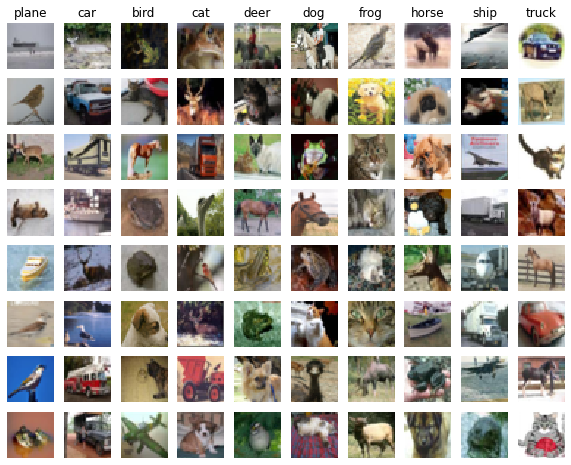

In [83]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$ The system tends to misclassify the images that contain the true class object appears with the similar enviroment of the class that the system try to predict, or classes with similar shape or color also be missclassify. For both cases, it makes sense, because we are using only the HOG and color histogram features, we are ony capturing the colors and texture in the images. So, the system tends to make mistakes because of the enviroment's texture and colors. For example, the system mixs up between planes, birds and ship and images of these classes have the very similar background color. It is also the case for cat and dog, or truck and car, when themself is very similar the other. However for some instances, it does not make sense. For example, when the system predict a truck is a cat, or a dog is a bird.




## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [93]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [117]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
num_classes = 10

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
best_net = None
best_val = -1

def generate_random_hyperparams(lr_min, lr_max, reg_min, reg_max, dim_min, dim_max):
  lr = 10**np.random.uniform(lr_min, lr_max)
  reg = 10**np.random.uniform(reg_min, reg_max)
  dim = np.random.randint(dim_min, dim_max)
  return lr, reg, dim

for _ in range(20):
  lr, reg, dim = generate_random_hyperparams(-1, 0, -7, -4, 10, 500)
  net = TwoLayerNet(input_size=input_dim, hidden_size=dim, output_size=num_classes)
  history = net.train(X_train_feats, y_train, X_val_feats, y_val, learning_rate=lr, 
                      reg=reg, batch_size=128, num_iters=4000, EarlyStopping=True, patience=700)
  y_pred = net.predict(X_val_feats)
  acc_val = np.mean(y_pred==y_val)
  acc_train = np.mean(net.predict(X_train_feats)==y_train)
  if acc_val > best_val:
    best_val = acc_val
    best_net = net
  print('lr: %f reg: %f hidden size: %d train acc: %f val acc: %f' % (lr, reg, dim, acc_train, acc_val))

print('best val accuracy: %f' % best_val)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


early stopping at iteration 3630 / 4000
best validation accuracy: 0.609000
lr: 0.174411 reg: 0.000003 hidden dim: 398 train acc: 0.694510 val acc: 0.605000
early stopping at iteration 2508 / 4000
best validation accuracy: 0.589000
lr: 0.254785 reg: 0.000002 hidden dim: 327 train acc: 0.674592 val acc: 0.580000
lr: 0.186172 reg: 0.000001 hidden dim: 41 train acc: 0.588204 val acc: 0.550000
early stopping at iteration 3844 / 4000
best validation accuracy: 0.594000
lr: 0.180866 reg: 0.000006 hidden dim: 157 train acc: 0.663327 val acc: 0.594000
lr: 0.118519 reg: 0.000002 hidden dim: 331 train acc: 0.663020 val acc: 0.597000
early stopping at iteration 2182 / 4000
best validation accuracy: 0.589000
lr: 0.298552 reg: 0.000010 hidden dim: 236 train acc: 0.659020 val acc: 0.579000
early stopping at iteration 2017 / 4000
best validation accuracy: 0.577000
lr: 0.486762 reg: 0.000002 hidden dim: 304 train acc: 0.660551 val acc: 0.561000
early stopping at iteration 1634 / 4000
best validation acc

In [118]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.599


---
# IMPORTANT

This is the end of this question. Please do the following:

1. Click `File -> Save` to make sure the latest checkpoint of this notebook is saved to your Drive.
2. Execute the cell below to download the modified `.py` files back to your drive.

In [121]:
import os

FOLDER_TO_SAVE = os.path.join('drive/My Drive/', FOLDERNAME)
FILES_TO_SAVE = []

for files in FILES_TO_SAVE:
  with open(os.path.join(FOLDER_TO_SAVE, '/'.join(files.split('/')[1:])), 'w') as f:
    f.write(''.join(open(files).readlines()))